In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

box_columns = ['Xmin','Ymin','Xmax','Ymax']

In [46]:
t_d = pd.read_csv('train_data.csv')
t_d_av = pd.read_csv('train_data_wav.csv')
t_a = pd.read_csv('train_answers.csv')

In [3]:
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]
itds = set(t_d['itemId'])
abx = np.array(t_d.loc[: 'itemId'][['Xmin','Ymin','Xmax','Ymax']])

In [57]:
obj = 16468
tdj = t_d[t_d['itemId'] == obj][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]
tavj = t_d_av[t_d_av['itemId'] == obj][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]
taj = t_a[t_a['itemId'] == obj][['Xmin_true','Ymin_true','Xmin_true','Ymax_true','Xmax_true','Ymax_true','Xmax_true','Ymin_true','Xmin_true','Ymin_true']]

(789, 1257)

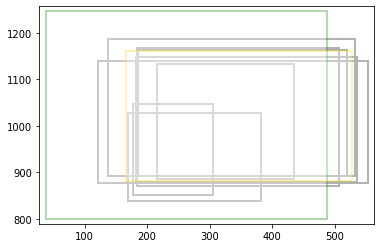

In [58]:
# weighted_averaging(t_d, 8774, abx, quorum)

tdv = []
tdc = []
tav = []
tac = []
qc = []
qv = []

Xmin,Ymin = 2000, 2000
Xmax,Ymax = 0, 0

def minMax(row, y):
    global Xmin,Xmax,Ymin,Ymax    
    Xmin = min(Xmin, row.iloc[y])
    Ymin = min(Ymin, row.iloc[y + 1])
    Xmax = max(Xmax, row.iloc[y])
    Ymax = max(Ymax, row.iloc[y + 1])

for i, row in tdj.iterrows():
    for y in range(0,10,2):
        minMax(row, y)
        tdv.append((row.iloc[y], row.iloc[y + 1]))
        tdc.append(codes[y//2])

for i, row in taj.iterrows():
    for y in range(0,10,2):
        minMax(row, y)
        tav.append((row.iloc[y], row.iloc[y + 1]))
        tac.append(codes[y//2])

for i, row in tavj.iterrows():
    for y in range(0,10,2):
        minMax(row, y)
        qv.append((row.iloc[y], row.iloc[y + 1]))
        qc.append(codes[y//2])
    
fig, ax = plt.subplots()
ax.add_patch(patches.PathPatch(Path(tdv, tdc), alpha=.3, facecolor='white', edgecolor='black', lw=2))
ax.add_patch(patches.PathPatch(Path(tav, tac), alpha=.3, facecolor='white', edgecolor='green', lw=2))
ax.add_patch(patches.PathPatch(Path(qv, qc), alpha=.3, facecolor='white', edgecolor='gold', lw=2))

ax.set_xlim(Xmin - 10, Xmax + 10)
ax.set_ylim(Ymin - 10, Ymax + 10)    